In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from EMG_gestures.utils import *

In [2]:
#randomly-selected subjects to use as hold-out test data 
test_subjects = [17, 23,  7,  8,  3]

In [3]:
nsubjects = 36

within_results_df = [] 

results_folder = '../results_data/single_subject_training/NN/model_comparison'
for src_subject_id in range(1,nsubjects+1):
    for model_id in range(5):
        results_fn = 'subject_%02d_model_%d_within_subject_results.h5'%(src_subject_id,model_id)
        subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
        subject_df['Train_Subject'] = subject_df['Subject']
        subject_df['Test_Subject'] = subject_df['Subject']
        subject_df['Model'] = model_id
        subject_df = subject_df.drop(columns = ['Subject'])
        within_results_df.append(subject_df)

within_results_df = pd.concat(within_results_df,axis = 0)


In [4]:

# Average over multiple train/test splits of the data
within_results_df = within_results_df.groupby(['Shuffled','Type','Train_Subject','Test_Subject','Model'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep'])

# Output summary
display(HTML(within_results_df.groupby(['Shuffled','Type','Model']).mean().drop(columns = ['Train_Subject','Test_Subject']).to_html()))

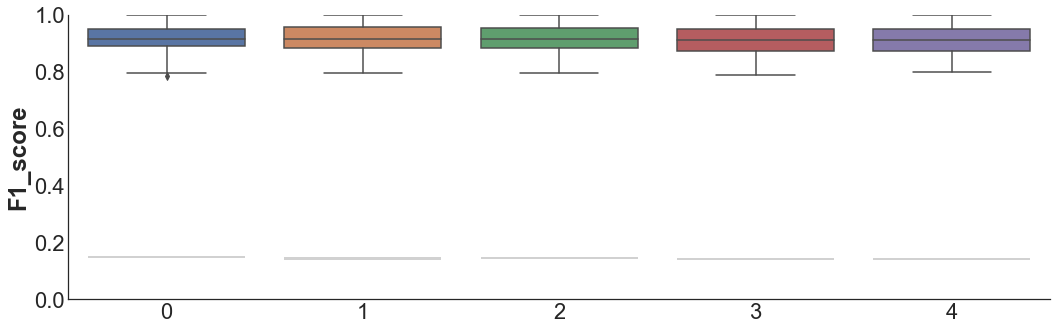

In [9]:
score2use = 'f1_score'
model_list = np.arange(0,5)

test_df = within_results_df.loc[within_results_df.Type=='Test']

shuffle_df = test_df.loc[test_df.Shuffled == True]
true_df = test_df.loc[test_df.Shuffled == False]

# Get confidence interval for shuffled data results
null_ci = np.zeros((len(model_list),2))

for j,t in enumerate(model_list):
    null_df = shuffle_df.loc[shuffle_df.Model == t]
    null_ci[j,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df[score2use].values))


#make plot
g = sns.catplot(data = true_df, x= 'Model', y = score2use,\
            order = model_list, kind = 'box', aspect = 3)

# #Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    ax.set_ylabel('F1_score')
    for j,t in enumerate(model_list):
        ax.add_patch(patches.Rectangle(((1*j)-.4, null_ci[j,0]), .8, (null_ci[j,1]-null_ci[j,0]),\
                                             linewidth=0, fill=True, color='k', alpha=0.2))

sns.despine(fig=g.fig, bottom = False)

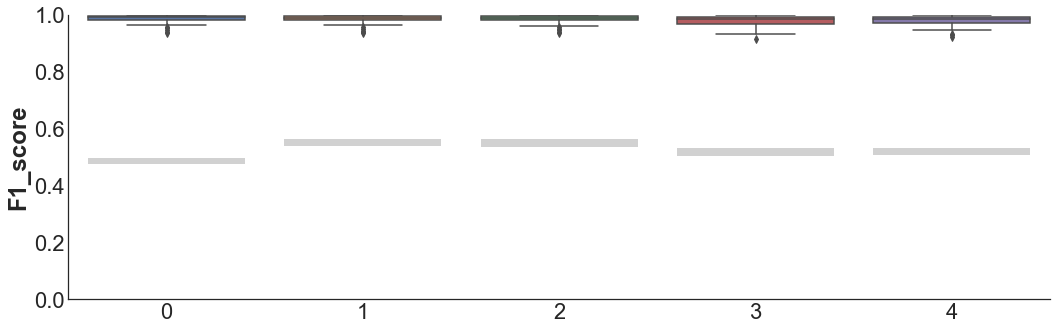

In [8]:
score2use = 'f1_score'
model_list = np.arange(0,5)

train_df = within_results_df.loc[within_results_df.Type=='Train']

shuffle_df = train_df.loc[train_df.Shuffled == True]
true_df = train_df.loc[train_df.Shuffled == False]

# Get confidence interval for shuffled data results
null_ci = np.zeros((len(model_list),2))

for j,t in enumerate(model_list):
    null_df = shuffle_df.loc[shuffle_df.Model == t]
    null_ci[j,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df[score2use].values))


#make plot
g = sns.catplot(data = true_df, x= 'Model', y = score2use,\
            order = model_list, kind = 'box', aspect = 3)

# #Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    ax.set_ylabel('F1_score')
    for j,t in enumerate(model_list):
        ax.add_patch(patches.Rectangle(((1*j)-.4, null_ci[j,0]), .8, (null_ci[j,1]-null_ci[j,0]),\
                                             linewidth=0, fill=True, color='k', alpha=0.2))

sns.despine(fig=g.fig, bottom = False)